In [18]:
import pandas as pd
import gc
gc.collect()
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")
web_scrapper_data = pd.read_csv("output.csv")

fake['target'] = 'fake'
true['target'] = 'true'

data = pd.concat([fake, true, web_scrapper_data]).reset_index(drop = True)


In [19]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)


data.drop(["title"],axis=1,inplace=True)
data.drop(["subject"],axis=1,inplace=True)
data.drop(["date"],axis=1,inplace=True)

In [20]:
data['text'] = data['text'].apply(lambda x: str(x))
data['text'] = data['text'].apply(lambda x: x.lower())

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [21]:
data


,text,target
0,lima reuters the peruvian attorney general s ...,true
1,washington the numbers are in according to th...,fake
2,donald trump has been raising a lot of eyebrow...,fake
3,everyone needs to read this letter click here ...,fake
4,washington reuters early optimism among busin...,true
...,...,...
73200,austin ruse of cfam a group that works to push...,fake
73201,washington reuters us secretary of state rex ...,true
73202,the us food and drug administration has for th...,fake
73203,when nadine quashie started work as a lap danc...,true


In [22]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shinj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


target
fake    39197
true    34008
Name: text, dtype: int64


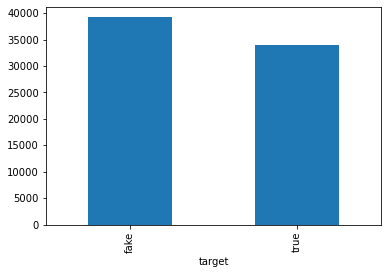

In [23]:
from matplotlib import pyplot as plt
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [24]:
from nltk import tokenize
import seaborn as sns
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

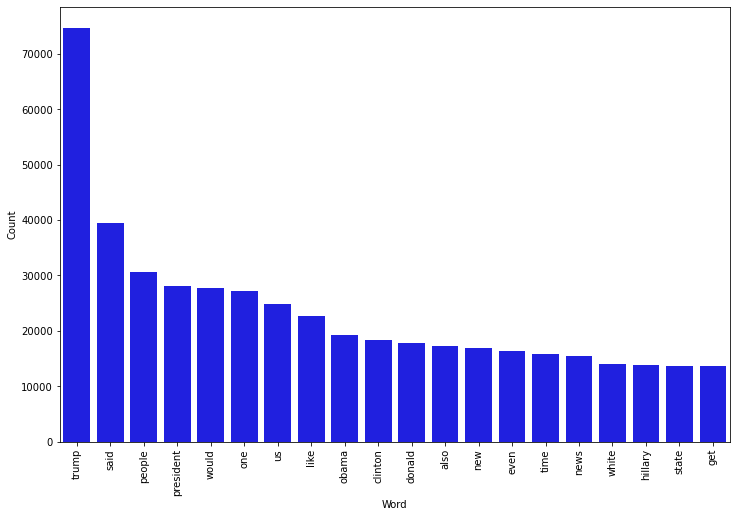

In [25]:
counter(data[data["target"] == "fake"], "text", 20)

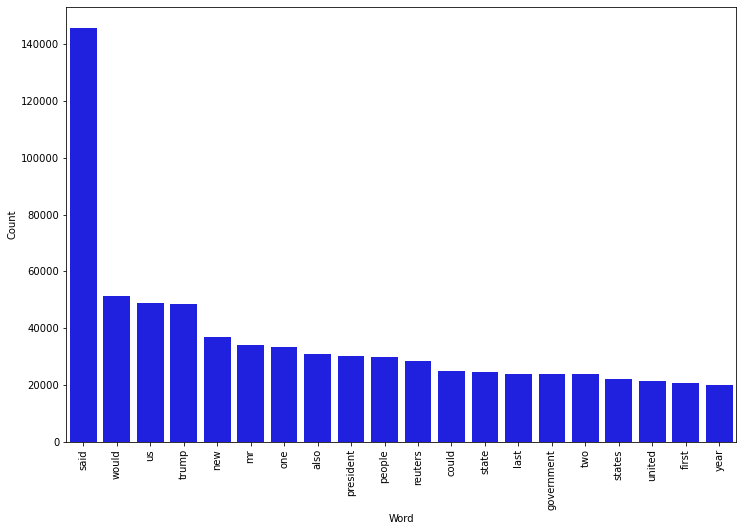

In [26]:
counter(data[data["target"] == "true"], "text", 20)

In [27]:
from sklearn import metrics
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [29]:
# Vectorizing and applying TF-IDF
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])# Fitting the model
model = pipe.fit(X_train, y_train)# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 97.48%


Confusion matrix, without normalization


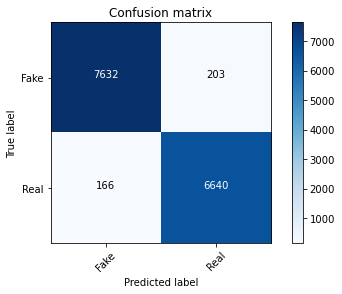

In [30]:
import numpy as np
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [31]:
from sklearn.tree import DecisionTreeClassifier# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 93.76%


Confusion matrix, without normalization


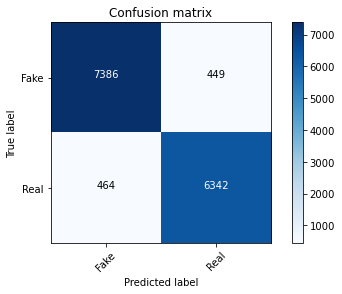

In [32]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [33]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 95.75%


Confusion matrix, without normalization


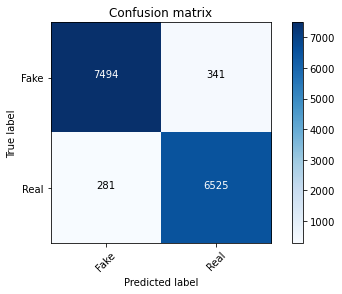

In [34]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])